<a href="https://colab.research.google.com/github/tinghe14/COURSE-2Deep-Learning/blob/main/RL_on_GCVM_0503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

shared URL for my drive: https://drive.google.com/drive/folders/1OGu5OMFOKKtjB8OAHxsxZ1_CErQRX-y8?usp=sharing (codes, saved model, data dictionary are there)

Trained Clustering CNN was saved in ting's shared drive location at /content/drive/MyDrive/DeepLearningFinalProject/clusteringCNN-flair.pt (epoch=10, batch_size=8, trained images=484)

Pesudolabel can be created by GenerateTarget function which you can learn by last section of "get masks" in this file

how the top 100 was created, you can check 'ting 0429 save target.ipynb', but don't need to read or run it for running this doc

In [ ]:
'''
What we will do in this script in order to retrieve those top 100 masks with their images:

STEP 1: import library as before 

STEP 2: run data loader to get top 100 dice score data path and conduct data transformer as before

STEP 3: load saved clustering CNN model and dice score image

STEP 4: run GenerateTarget function to get the masks (here only show one example in order to let you know how it work)
'''

'\nWhat we will do in this script in order to retrieve those top 100 masks with their images:\n\nSTEP 1: import library as before \n\nSTEP 2: run data loader to get top 100 dice score data path and conduct data transformer as before\n\nSTEP 3: load saved clustering CNN model and dice score image\n\nSTEP 4: run GenerateTarget function to get the masks (here only show one example in order to let you know how it work)\n'

# Library

In [ ]:
%pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"
import warnings
warnings.filterwarnings("ignore")  # remove some scikit-image warnings

import monai
monai.config.print_config()

# access dataset from data challenge 
#from monai.apps import DecathlonDataset
# dataloader to prepare it ready for dl model
from monai.data import DataLoader
from monai.metrics import DiceMetric
# chain of transformers (if want to add more: check the documentations in transform, loader section)
# from monai.transforms import \
#     LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, \
#     AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD
from monai.transforms import (
    OrientationD,
    Activations,
    AddChannelD,
    AsDiscreteD,
    Compose,
    LoadImageD,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityD,
    EnsureTyped,
    EnsureType,
    SpacingD,
    RandAffineD,
    ResizeD,
    EnsureChannelFirstD,
    ToTensorD,
    MapTransform
)

import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn.modules.activation import Softmax
import torchvision.utils as vutils


%matplotlib inline

MONAI version: 0.9.dev2216
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1c4fae6a91eba8262de2c1a9665055edcd5605f3
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 4.4.0
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Data Loader

In [ ]:
# for 100 images 
from glob import glob
from pathlib import Path

import pandas as pd

top100id = pd.read_csv('/content/top100id.csv')

top100path_T = []
for i in top100id.iloc[:,0]:
 top100path_T.append(Path("/content/Task01_BrainTumour/imagesTr/BRATS_{:03d}.nii.gz".format(i)))

top100path_L = []
for i in top100id.iloc[:,0]:
 top100path_L.append(Path("/content/Task01_BrainTumour/labelsTr/BRATS_{:03d}.nii.gz".format(i)))

top100path_T = sorted(top100path_T)
top100path_L = sorted(top100path_L)

In [ ]:
# for 100 images 
from glob import glob
from pathlib import Path

ROOT_DIR = "/content/Task01_BrainTumour"
img_root = ROOT_DIR+"/imagesTr"
label_root = ROOT_DIR+ "/labelsTr"

img_dir = Path(img_root)
label_dir = Path(label_root)

images= top100path_T
segs = top100path_L

print("num of images in training image folder: ", len(images))
print("num of label in training label folder: ", len(segs))

# 60 images for training
train_5 = [{"img": img, "seg": seg} for img, seg in zip(images[:60], segs[:60])]
print("num of images in our train_5: ", len(train_5))
val_data = [{"img": img, "seg": seg} for img, seg in zip(images[60:80], segs[60:80])]
print("num of images in our val_data: ", len(val_data))
test_data = [{"img": img, "seg": seg} for img, seg in zip(images[80:], segs[80:])]
print("num of images in our test_data: ", len(test_data))

num of images in training image folder:  100
num of label in training label folder:  100
num of images in our train_5:  60
num of images in our val_data:  20
num of images in our test_data:  20


In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # background
            result.append(d[key] == 0)
            #print(result)
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32) 
        return d

In [ ]:
# To-do: dataloader for validation and test
# start a chain of transforms
keys = ["img", "seg"]

class Select():
    """Convert 4-channel input/target to 1-channel input/target. 
    For input, only select FLAIR channel of the input, ie, channel 0
    For target, only select Whole Tumor channel of the target, ie, channel 2

    Args:
        channel (int): 
    """

    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        image, landmarks = sample[self.keys[0]], sample[self.keys[1]]
        image = torch.unsqueeze(image[0,...], 0)  # 0 is FLAIR
        landmarks = torch.unsqueeze(landmarks[2,...],0)  # 2 is whole tumor

        return {self.keys[0]: image, self.keys[1]: landmarks}

train_transforms = Compose(
    [
        LoadImageD(keys),
        EnsureChannelFirstD("img"), # move modailty to the second place (first position: batch)
        ConvertToMultiChannelBasedOnBratsClassesd(keys='seg'),
        #AddChannelD("seg"), # add modality label for label # don't run this line once converted the label
        OrientationD(keys, axcodes='RAS'), #convert RAS coordinate system,
        SpacingD(keys, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')), # scale image (detials:https://docs.monai.io/en/stable/transforms.html?highlight=spacingD#:~:text=Spatial%20(Dict)-,Spacingd,-%C2%B6)
        ScaleIntensityD(keys="img"),
        ResizeD(keys, (64, 64, 32), mode=('trilinear', 'nearest')), # resize (specific interpolate mode ) ## TODO: find a way to chrop the image, maybe: https://docs.monai.io/en/0.1.0/transforms.html?highlight=crop#centerspatialcrop
        # feel free to uncomment some augumentation techniques
        #RandCropByPosNegLabeld(
            #keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        #),
        #RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        ##CenterScaleCropd(keys, roi_scale=0.8)
        EnsureTyped(keys),
        ToTensorD(keys),
        Select(keys)
    ]
)

In [ ]:
# define dataset, data loader
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
new_ds = monai.data.Dataset(data=train_5, transform=train_transforms)
train_loader = DataLoader(new_ds, batch_size=1, shuffle=False, num_workers=3, collate_fn=list_data_collate,pin_memory=torch.cuda.is_available())
new_ds = monai.data.Dataset(data=val_data, transform=train_transforms)
val_loader = DataLoader(new_ds, batch_size=1, shuffle=False, num_workers=3, collate_fn=list_data_collate,pin_memory=torch.cuda.is_available())
new_ds = monai.data.Dataset(data=test_data, transform=train_transforms)
test_loader = DataLoader(new_ds, batch_size=1, shuffle=False, num_workers=3, collate_fn=list_data_collate,pin_memory=torch.cuda.is_available())

# Load Model


In [ ]:
from google.colab import output
class clusteringCNN(nn.Module):
    # initializers
    def __init__(self,num_modality,output_channel):
        super(clusteringCNN, self).__init__()
        #TODO
        # Note: input and the output should be the same size,
        # in order to do the superpixel step
        # WHY? before I used stride=0, padding=0, as parameters in paper but it gives me error: pytorch conv3d non-postive stride is not supported (which didn't make sense)
        self.layer1 =nn.Conv3d(in_channels=num_modality, out_channels=100, kernel_size=3, stride=1, padding=1)  #[Batch, Channel, Slice, H, W]
        self.bn1 = torch.nn.InstanceNorm3d(100)
        self.layer2 = nn.Conv3d(100, 100, 3, stride=1, padding=1)
        self.bn2 = torch.nn.InstanceNorm3d(100)
        self.layer3 = nn.Conv3d(100, output_channel, 3, stride=1, padding=1)
        self.bn3 = torch.nn.InstanceNorm3d(output_channel) 

        
    # Init linear layers
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = input
        x = self.bn1(nn.functional.relu(self.layer1(x)))
        x = self.bn2(nn.functional.relu(self.layer2(x)))
        x = self.bn3(self.layer3(x))
        # x,_ = torch.argmax(x, dim=1) # don't need argmax in the training, we only need it in creating target
        return x

In [ ]:
from skimage.segmentation import slic, mark_boundaries
import torch.nn.functional as F

def GenerateTarget(original_input, batch,  clusterCNN_output):
  '''
  NOTE: might need to modify some code if batch_size > 1
  step A: draw superpixels on original image
  step B: apply superpixels on model_output to "segment" different parts
  step C: copy a zero tensor as model_output 
  step D: for each superpixel/part:
            find the mode in that part,
            fill the mode all over that part
          generate the tensor filled in the modes
  step E: now have the pesudolabel out of the superpixels and cluster CNN
  @params: 
  original_input: original image [B, C=1/FLAIR, H, W, Slice] 
  clusterCNN_output: pred from clustering CNN in [B, Cluster, Slice, H, W]
  @output: 
  [B, H, W, Slice, C=1] 
  '''
  ## STEP A
  original_input2 = original_input/255 # size of [B, C, Slice, H, W]
  input_super = slic(original_input2[batch,0,...].detach().cpu().numpy(), multichannel=False, convert2lab=True,n_segments=500, sigma=1, enforce_connectivity=False, compactness=0.0001) # 64, 64, 32
  
  ## STEP B
  input_super_tensor = torch.from_numpy(input_super)
  input_super_onehot = F.one_hot(input_super_tensor, num_classes = -1)
  num_superpixel = input_super_onehot.size(3)

  ## STEP C
  temp = torch.clone(input_super_onehot) # [H, W, Slice, Num_superclass]

  ## STEP D
  clusterCNN_output_argmax = torch.argmax(clusterCNN_output,dim=1,keepdim= True)+1 #+1 in order to find mode, no mess up with other meaning of 0(one hot encoding og label)

  for i in range(num_superpixel):
    plus = torch.mul(clusterCNN_output_argmax.to('cuda'),input_super_onehot[...,i].to('cuda'))
    plus2 = torch.reshape(plus, (-1,))
    mode_i, _ = torch.mode(plus2[plus2!=0])
    mode_i3 = mode_i.long()
    temp[...,i][temp[...,i]!=0] = mode_i3-1 # delete the 1 which we add before
  pesudolabel = torch.sum(temp, dim=3, keepdim=True) # [64, 64, 32, 1]
  return pesudolabel

In [ ]:
from collections import defaultdict

def dice_score_image(pesudo, truelabel):
  '''
    computer the mean dice score for every class in a single image

    Args:
        pesudo(tensor): predictied labels of the image, [H, W, Slice, C=1] (before one hot)
        truelabel (tensor): ground truth of the image [B, C=1, H, W, Slice] when choosing C=0, it is the whole tumor we want
  
    Returns:
        one_score_list: dict {index of class(int): dice score for that class (float)}(for one image)
  '''

  pesudo_onehot = F.one_hot(pesudo, num_classes=6) #[H, W, Slice, 1, C=24]; output has 6 channels/masks
  class6 = pesudo_onehot.size(4) 
  
  pesudo2_onehot = torch.permute(pesudo_onehot, (3,0,1,2,4)) #[B, H,W,Slice,Class=24]
  truelabel2 = torch.permute(truelabel,(0,2,3,4,1)) 
  truelabel_flat = truelabel2[0,...].contiguous().view(-1) #chose whole tumor

  one_score_list = defaultdict()
  for i in range(class6):
    pesudo_i_flat = pesudo2_onehot[0,...,i].contiguous().view(-1)
    TP_i = ((pesudo_i_flat == 1) * (truelabel_flat == 1)).sum().item()
    FP_i = ((pesudo_i_flat == 1) * (truelabel_flat != 1)).sum().item()
    FN_i = ((pesudo_i_flat != 1) * (truelabel_flat == 1)).sum().item()
    cal = (2 * TP_i) / (2 * TP_i + FP_i + FN_i)
    one_score_list[i] = cal 

  return one_score_list

In [ ]:
model = torch.load('/content/clusteringCNN-flair0503.pt')
model.eval()

clusteringCNN(
  (layer1): Conv3d(1, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): InstanceNorm3d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (layer2): Conv3d(100, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): InstanceNorm3d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (layer3): Conv3d(100, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): InstanceNorm3d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

# Get Masks

In [ ]:
# output of dice_score_image
# dict 
# key: index of class(int) [from 0 to 23]
# value: dice score in that index
from torch.autograd import Variable

for i,single in enumerate(train_loader):
  if i < 5:
    pred = model(Variable(single['img'].cuda(), requires_grad=True))
    pesudolabel = GenerateTarget(single['img'], 0, pred)
    batch = 0
    a = dice_score_image(pesudolabel,single['seg'])
    a = sorted(a,reverse=True)
    print(dice_score_image(pesudolabel,single['seg']))
    print("-------NEW IMAGE---------------")
  else:
    break

defaultdict(None, {0: 0.1294245663444921, 1: 0.0, 2: 0.0, 3: 0.5574402467232074, 4: 0.005521928427312308, 5: 0.0})
-------NEW IMAGE---------------
defaultdict(None, {0: 0.24375829212398986, 1: 0.004589585172109444, 2: 0.0, 3: 0.39481865284974094, 4: 0.05265109380793474, 5: 0.0})
-------NEW IMAGE---------------
defaultdict(None, {0: 0.11187812425612949, 1: 0.0, 2: 0.0, 3: 0.6533551554828151, 4: 0.013856362217017954, 5: 0.0})
-------NEW IMAGE---------------
defaultdict(None, {0: 0.0378792448277942, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.00243605359317905, 5: 0.0})
-------NEW IMAGE---------------
defaultdict(None, {0: 0.062192589354027765, 1: 0.0009732360097323601, 2: 0.0, 3: 0.520471894517696, 4: 0.00019297568506368199, 5: 0.0})
-------NEW IMAGE---------------


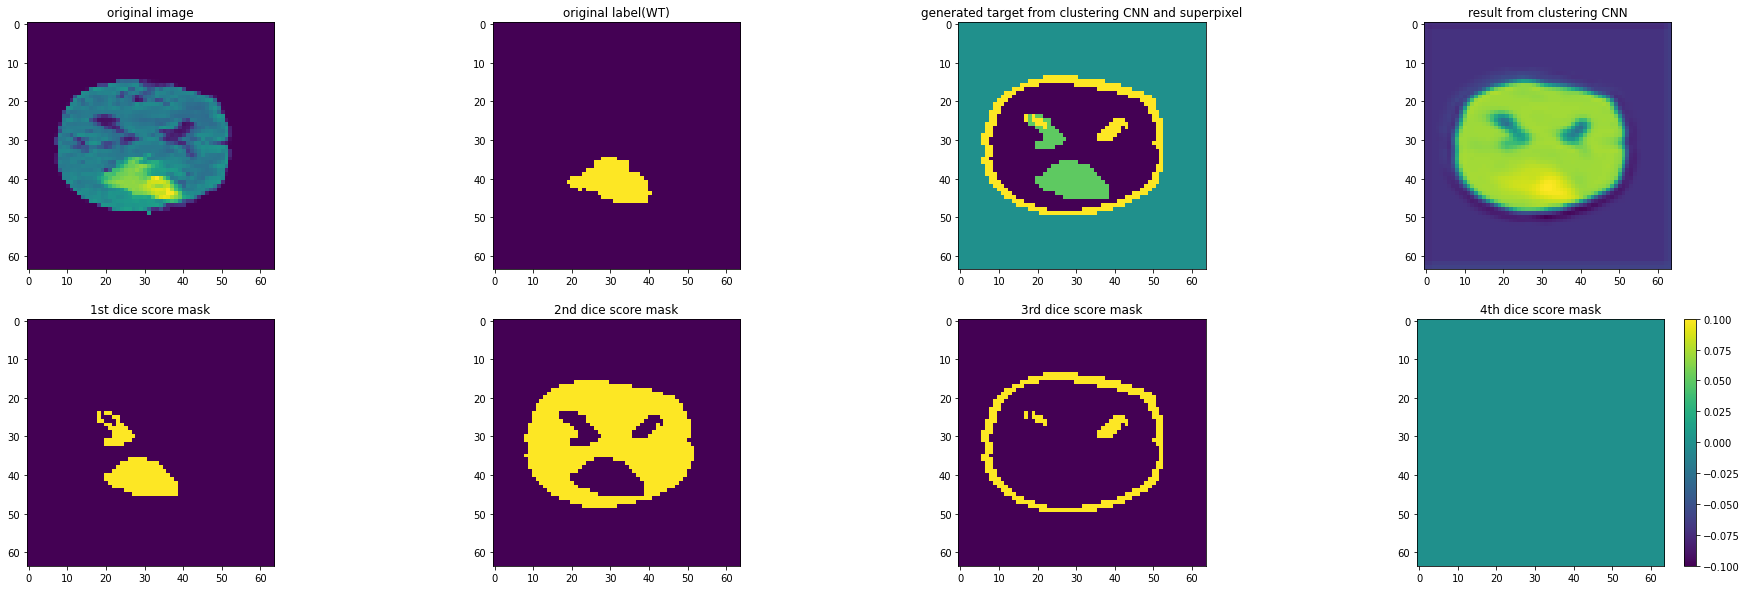

In [ ]:
# test Dice score in one target (corresponding to the first dict)
# defaultdict(None, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.010606703436571913, 10: 0.0, 11: 0.49771487542385373, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.007695060844667144, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0011757789535567313, 24: 0.0})

first = monai.utils.misc.first(train_loader)
pred = model(Variable(first['img'].cuda(), requires_grad=True))
pesudolabel = GenerateTarget(first['img'], 0, pred)
batch = 0

pesudo_onehot = F.one_hot(pesudolabel, num_classes=-1)

plt.subplots(2,4,figsize=(32,10))
plt.subplot(2,4, 1);plt.imshow(first['img'].detach().cpu().numpy()[batch,0,...,16]);plt.title("original image")
plt.subplot(2,4, 2);plt.imshow(first['seg'].detach().cpu().numpy()[batch,0,...,16]);plt.title("original label(WT)")
plt.subplot(2,4, 3);plt.imshow(pesudolabel[...,16,0]);plt.title("generated target from clustering CNN and superpixel")
plt.subplot(2,4,4);plt.imshow(pred[batch,0,...,16].cpu().detach().numpy());plt.title("result from clustering CNN")
plt.subplot(2,4, 5);plt.imshow(pesudo_onehot[...,16,0,3].detach().cpu().numpy());plt.title("1st dice score mask")
plt.subplot(2,4, 6);plt.imshow(pesudo_onehot[...,16,0,0].detach().cpu().numpy());plt.title("2nd dice score mask")
plt.subplot(2,4, 7);plt.imshow(pesudo_onehot[...,16,0,4].detach().cpu().numpy());plt.title("3rd dice score mask")
plt.subplot(2,4,8);plt.imshow(pesudo_onehot[...,16,0,1].cpu().detach().numpy());plt.title("4th dice score mask")
plt.colorbar()

# DICE score for all

In [ ]:
def dice_score_all(data_loader):
  all_score_list = {}
  for i,single in enumerate(data_loader):
    pred_i = model(Variable(single['img'].cuda(), requires_grad = True))
    pesudo_i = GenerateTarget(single['img'], 0, pred_i)
    truelabel_i = single['seg']
    one_image_score = dice_score_image(pesudo_i,truelabel_i)
    all_score_list[i] = one_image_score
    print('now processing the', i, 'th image')
  return all_score_list

In [ ]:
data_dictionary = dice_score_all(train_loader)

now processing the 0 th image
now processing the 1 th image
now processing the 2 th image
now processing the 3 th image
now processing the 4 th image
now processing the 5 th image
now processing the 6 th image
now processing the 7 th image
now processing the 8 th image
now processing the 9 th image
now processing the 10 th image
now processing the 11 th image
now processing the 12 th image
now processing the 13 th image
now processing the 14 th image
now processing the 15 th image
now processing the 16 th image
now processing the 17 th image
now processing the 18 th image
now processing the 19 th image
now processing the 20 th image
now processing the 21 th image
now processing the 22 th image
now processing the 23 th image
now processing the 24 th image
now processing the 25 th image
now processing the 26 th image
now processing the 27 th image
now processing the 28 th image
now processing the 29 th image
now processing the 30 th image
now processing the 31 th image
now processing the

In [ ]:
data_dictionary

By now just by eyeballing one should be able to tell the channel with highest score is the correct masks aka target

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 4.1 GB  | Proc size: 3.8 GB
GPU RAM Free: 10062MB | Used: 5047MB | Util  33% | Total 15109MB


#RL

In [ ]:
import typing

import torch
from torch import nn


DQNet = nn.Module


class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)


def make_deep_q_network_fn(action_size: int) -> typing.Callable[[], DQNet]:
    
    def deep_q_network_fn() -> DQNet:
        q_network = nn.Sequential(
            nn.Conv3d(in_channels=2, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
            nn.ReLU(),
            LambdaLayer(lambda tensor: tensor.view(tensor.size(0), -1)),
            nn.Linear(in_features=1600, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=action_size)
        )
        return q_network
    
    return deep_q_network_fn

In [ ]:
import collections
import typing


_field_names = [
    "episode_no",
    "action",
    "reward",
    "state"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class ExperienceReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
        
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return len(self._buffer)
    
    @property
    def batch_size(self) -> int:
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        return self._buffer_size

    def is_full(self) -> bool:
        return len(self._buffer) == self._buffer_size
    
    def append(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        self._buffer.append(experience)
    
    def sample(self) -> typing.List[Experience]:
        """Randomly sample a batch of experiences from memory."""
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences


In [ ]:
import random, math
def select_learning_rate(x):
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x+1)/6)))

# change the exploration rate over time.
def select_explore_rate(x):
    return max(min_explore_rate, min(1.0, 1.0 - math.log10((x+1)/6)))

# NOT USED by DQN
def select_action(state_value, explore_rate, model): 
    if random.random() < explore_rate:
        action = np.random.choice(action_sapce) # explore
    else: 
      action = np.argmax(q_value_table[state_value])# exploit
    return action

def get_reward(a, t, prev):
  if prev ==  t and a == t :
    return 5
  elif prev !=t and a != prev:
    return 0
  else:
    return -1

def get_image(model, grayscale_img,episode_no,prev_state: torch.long) -> torch.Tensor:
  mask = model(grayscale_img)[:,prev_state:prev_state+1,...]
  return torch.cat((grayscale_img, mask), dim=1)

In [ ]:
# initialization
all_actions = 6    # suppose to be 6 classes
all_states = 6
action_sapce = np.arange(all_actions)
q_value_table = np.zeros((all_states,all_actions))
total_iter = 0
reward_over_eps = []
reward_step_history = 0
device = torch.device("cuda") 

# user-defined parameters
min_explore_rate = 0.001; min_learning_rate = 0.1;
max_steps=200; num_of_images = 1; max_episodes = num_of_images *max_steps;
discount = 0.99
batch_size = 1
learning_rate = 1e-3

# initialize DQN & buffer
Qmodel = make_deep_q_network_fn(all_actions)
Qmodel = Qmodel().to(device)
Qmodel.train()
optimizer = optim.SGD(Qmodel.parameters(), lr = learning_rate, momentum = 0.9)
memory = ExperienceReplayBuffer(batch_size, buffer_size=1000)

# train the system
for episode_no,batch in enumerate(train_loader):
    prev_state = 1
    learning_rate = select_learning_rate(episode_no)
    explore_rate = select_explore_rate(episode_no)
    ep_reward = 0
    for _ in range(max_steps): # the agent was allowed to sample for 20 steps acc. to paper
        # select action using epsilon-greedy policy
        if random.random() < explore_rate:
          # explore
            action = np.random.choice(action_sapce)
        else: 
          # exploit
          with torch.no_grad():
            image= get_image(model, batch['img'].to(device), episode_no, prev_state)
            pred_q_values = Qmodel(image).detach().cpu()
            action = np.argmax(pred_q_values).item()


        # record new observations
        target = max(data_dictionary[episode_no], key=data_dictionary[episode_no].get)
        state, reward_gain= action, get_reward(action, target, prev_state)

        ep_reward += reward_gain

        # Store data into memory
        experience = (episode_no, action, reward_gain, prev_state)
        memory.append(experience)

        # # update q_value_table
        # best_q = max(q_value_table[state])
        # sample = reward_gain + discount * best_q
        # q_value_table[prev_state][action] += learning_rate * (sample - q_value_table[prev_state][action])

        # update DQN
        if total_iter > 100:
          #TODO sample data with batch_size from memory
            experience = memory.sample()[0]
            eps_no, current_action, reward_gain, prev_state = experience
            image = get_image(model, batch['img'].to(device), eps_no, prev_state)

            QmodelOut = Qmodel(Variable(image, requires_grad=True))
            expected_q_values = QmodelOut[0][prev_state]

            # calculate target_q by calculating the optimal Q of the next state-action
            optm_q = max(QmodelOut[0])
            target_q = reward_gain + discount * optm_q

            # compute the mean squared loss
            # print(expected_q_values.item(), target_q.item())
            loss = F.mse_loss(expected_q_values, target_q)
            # print(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            total_iter += 1

        prev_state = state        
    reward_over_eps.append(ep_reward)
    print(ep_reward, QmodelOut)
    if episode_no  == 25: # early stopping to avoid NaN
      break

-29 tensor([[-0.0177,  0.0092,  0.1533, -0.0006, -0.0221, -0.0790]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
-24 tensor([[-0.0260,  0.0212,  0.0848, -0.0050, -0.0474,  0.0003]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
-24 tensor([[-0.0520,  0.0396,  0.1246, -0.0418, -0.0629,  0.0182]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
-42 tensor([[-0.0281,  0.0082,  0.0976, -0.0192, -0.0399,  0.0029]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
-33 tensor([[-0.1236, -0.0093,  0.2247, -0.0699,  0.0053, -0.0076]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
-11 tensor([[-0.0313,  0.0002,  0.0950, -0.0446,  0.0026,  0.0095]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
10 tensor([[-0.0853,  0.0080,  0.0998, -0.0202,  0.0007,  0.0211]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
29 tensor([[-0.0899,  0.0145,  0.1235,  0.0010,  0.0016, -0.0309]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
68 tensor([[-0.0630, -0.0692,  0.2159, -0.0507, -0

## cumulative reward vs eposoid

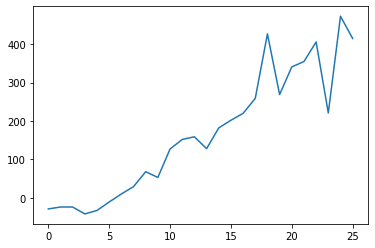

In [ ]:

plt.plot(range(len(reward_over_eps)), reward_over_eps)

### check prediction of Qmodel

In [ ]:
for episode_no,batch in enumerate(test_loader):
    L = []
    for i in range(6):
        image= get_image(model, batch['img'].to(device), episode_no, i)
        pred_q_values = Qmodel(image).detach().cpu()

        action = np.argmax(pred_q_values).item()
        L.append(action)
    target = max(data_dictionary[episode_no], key=data_dictionary[episode_no].get)
    print(L, target)

[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2
[2, 2, 2, 2, 2, 2] 2


# test dice score

In [ ]:
def dice_score_all(data_loader):
  all_score_list = {}
  for i,single in enumerate(data_loader):
    pred_i = model(Variable(single['img'].cuda(), requires_grad = False))
    pesudo_i = GenerateTarget(single['img'], 0, pred_i)
    truelabel_i = single['seg']
    one_image_score = dice_score_image(pesudo_i,truelabel_i)
    all_score_list[i] = one_image_score
    print('now processing the', i, 'th image')
  return all_score_list

test_data_dictionary = dice_score_all(test_loader)

# torch.save(Qmodel,'/content/Qmodel_data100.pt') 
L2 = np.zeros(len(test_loader),)
for episode_no,batch in enumerate(test_loader):
    L=[]
    for i in range(6):
        image= get_image(model, batch['img'].to(device), episode_no, i)
        pred_q_values = Qmodel(image).detach().cpu()
        action = np.argmax(pred_q_values).item()
        L.append(action)
    pred = 2 # supposed-implementationw/ for loop: pred = idx if idx == L[idx]
    dice_score_per_channel_per_image = test_data_dictionary[episode_no][pred]
    L2[episode_no] = dice_score_per_channel_per_image
print('avg dice score of test set:',L2.mean())

now processing the 0 th image
now processing the 1 th image
now processing the 2 th image
now processing the 3 th image
now processing the 4 th image
now processing the 5 th image
now processing the 6 th image
now processing the 7 th image
now processing the 8 th image
now processing the 9 th image
now processing the 10 th image
now processing the 11 th image
now processing the 12 th image
now processing the 13 th image
now processing the 14 th image
now processing the 15 th image
now processing the 16 th image
now processing the 17 th image
now processing the 18 th image
now processing the 19 th image
avg dice score of test set: 0.7311871575310268


In [ ]:
test_data_dictionary


{0: defaultdict(None,
             {0: 0.0,
              1: 0.2178988326848249,
              2: 0.8014605203103605,
              3: 0.0,
              4: 0.14959016393442623,
              5: 0.0}),
 1: defaultdict(None,
             {0: 0.0,
              1: 0.210016155088853,
              2: 0.7316933638443935,
              3: 0.0,
              4: 0.23853606027987082,
              5: 0.0}),
 2: defaultdict(None,
             {0: 0.0,
              1: 0.2421917808219178,
              2: 0.8049180327868852,
              3: 3.0998140111593304e-05,
              4: 0.10980392156862745,
              5: 0.0}),
 3: defaultdict(None,
             {0: 0.0,
              1: 0.18207282913165265,
              2: 0.6889507892293407,
              3: 1.5386745857118676e-05,
              4: 0.17013232514177692,
              5: 0.0}),
 4: defaultdict(None,
             {0: 0.0,
              1: 0.24,
              2: 0.7832699619771863,
              3: 0.0,
              4: 0.115627822

##produce images

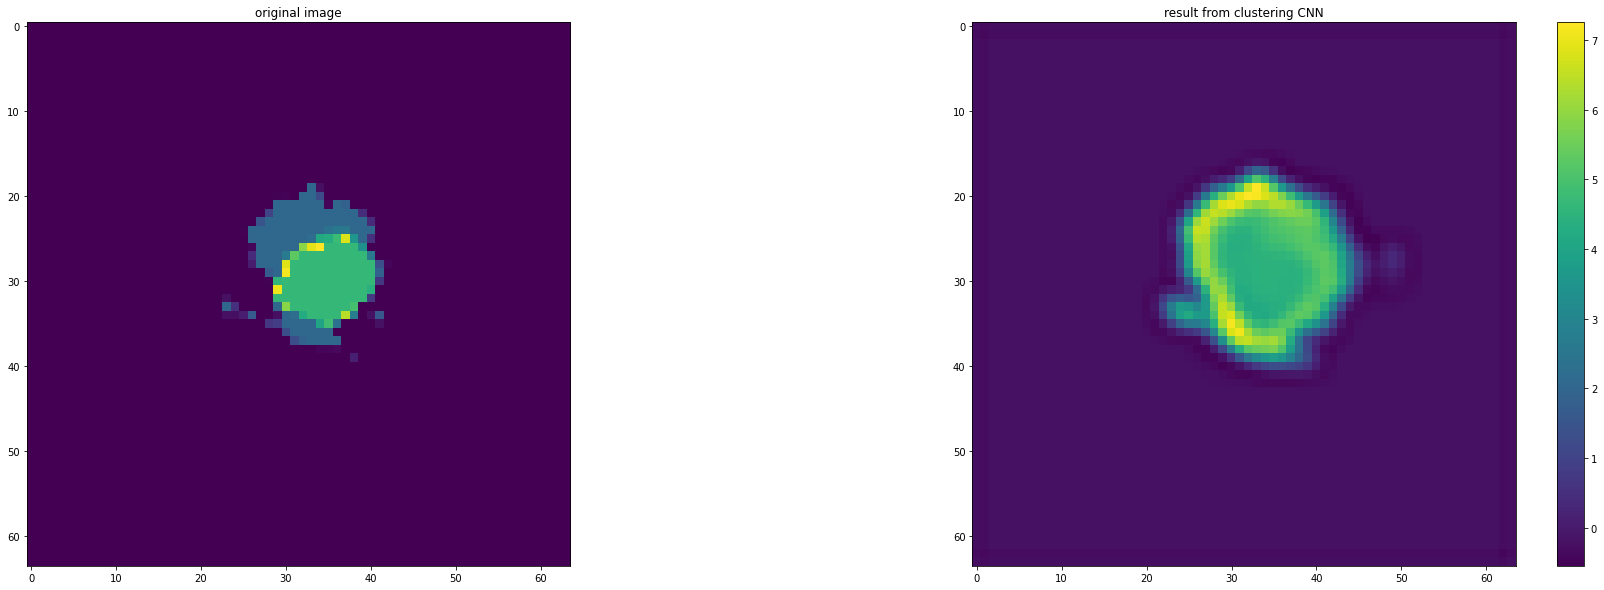

In [ ]:
# test Dice score in one target
plt.subplots(2,2,figsize=(32,10))
plt.subplot(1,2, 1);plt.imshow(batch['img'].detach().cpu().numpy()[0,0,...,16]);plt.title("original image")
plt.subplot(1,2,2);plt.imshow(image[0,1,...,16].cpu().detach().numpy());plt.title("result from clustering CNN")
plt.colorbar()